# 1. Data Loading and Libraries

In [122]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.model_selection import train_test_split, cross_val_score, GridSearchCV
from sklearn.preprocessing import LabelEncoder
from imblearn.over_sampling import SMOTE
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier, VotingClassifier
from xgboost import XGBClassifier
from sklearn.metrics import (
    accuracy_score, confusion_matrix, roc_auc_score, f1_score,
    precision_score, recall_score, roc_curve, classification_report
)
from imblearn.over_sampling import SMOTE
import warnings

warnings.filterwarnings('ignore')
sns.set(style='whitegrid')

In [123]:
# load the dataset
df = pd.read_csv('Telco-Customer-Churn.csv')

In [124]:
df.head()

,customerID,gender,SeniorCitizen,Partner,Dependents,tenure,PhoneService,MultipleLines,InternetService,OnlineSecurity,...,DeviceProtection,TechSupport,StreamingTV,StreamingMovies,Contract,PaperlessBilling,PaymentMethod,MonthlyCharges,TotalCharges,Churn
0,7590-VHVEG,Female,0,Yes,No,1,No,No phone service,DSL,No,...,No,No,No,No,Month-to-month,Yes,Electronic check,29.85,29.85,No
1,5575-GNVDE,Male,0,No,No,34,Yes,No,DSL,Yes,...,Yes,No,No,No,One year,No,Mailed check,56.95,1889.5,No
2,3668-QPYBK,Male,0,No,No,2,Yes,No,DSL,Yes,...,No,No,No,No,Month-to-month,Yes,Mailed check,53.85,108.15,Yes
3,7795-CFOCW,Male,0,No,No,45,No,No phone service,DSL,Yes,...,Yes,Yes,No,No,One year,No,Bank transfer (automatic),42.30,1840.75,No
4,9237-HQITU,Female,0,No,No,2,Yes,No,Fiber optic,No,...,No,No,No,No,Month-to-month,Yes,Electronic check,70.70,151.65,Yes


In [125]:
df.shape

(7043, 21)

# 2. Data Preprocessing

In [126]:
# Drop customerID column (not useful for modeling)
df = df.drop(columns=["customerID"])

In [127]:
df.columns

Index(['gender', 'SeniorCitizen', 'Partner', 'Dependents', 'tenure',
       'PhoneService', 'MultipleLines', 'InternetService', 'OnlineSecurity',
       'OnlineBackup', 'DeviceProtection', 'TechSupport', 'StreamingTV',
       'StreamingMovies', 'Contract', 'PaperlessBilling', 'PaymentMethod',
       'MonthlyCharges', 'TotalCharges', 'Churn'],
      dtype='object')

In [128]:
# print the unique value
for col in df.columns:
    print(f"{col}: {df[col].unique()}")
    print("-"*50)

gender: ['Female' 'Male']
--------------------------------------------------
SeniorCitizen: [0 1]
--------------------------------------------------
Partner: ['Yes' 'No']
--------------------------------------------------
Dependents: ['No' 'Yes']
--------------------------------------------------
tenure: [ 1 34  2 45  8 22 10 28 62 13 16 58 49 25 69 52 71 21 12 30 47 72 17 27
  5 46 11 70 63 43 15 60 18 66  9  3 31 50 64 56  7 42 35 48 29 65 38 68
 32 55 37 36 41  6  4 33 67 23 57 61 14 20 53 40 59 24 44 19 54 51 26  0
 39]
--------------------------------------------------
PhoneService: ['No' 'Yes']
--------------------------------------------------
MultipleLines: ['No phone service' 'No' 'Yes']
--------------------------------------------------
InternetService: ['DSL' 'Fiber optic' 'No']
--------------------------------------------------
OnlineSecurity: ['No' 'Yes' 'No internet service']
--------------------------------------------------
OnlineBackup: ['Yes' 'No' 'No internet service

In [129]:
# Convert 'TotalCharges' to numeric, handle missing value
df[df['TotalCharges'] == " "]

,gender,SeniorCitizen,Partner,Dependents,tenure,PhoneService,MultipleLines,InternetService,OnlineSecurity,OnlineBackup,DeviceProtection,TechSupport,StreamingTV,StreamingMovies,Contract,PaperlessBilling,PaymentMethod,MonthlyCharges,TotalCharges,Churn
488,Female,0,Yes,Yes,0,No,No phone service,DSL,Yes,No,Yes,Yes,Yes,No,Two year,Yes,Bank transfer (automatic),52.55,,No
753,Male,0,No,Yes,0,Yes,No,No,No internet service,No internet service,No internet service,No internet service,No internet service,No internet service,Two year,No,Mailed check,20.25,,No
936,Female,0,Yes,Yes,0,Yes,No,DSL,Yes,Yes,Yes,No,Yes,Yes,Two year,No,Mailed check,80.85,,No
1082,Male,0,Yes,Yes,0,Yes,Yes,No,No internet service,No internet service,No internet service,No internet service,No internet service,No internet service,Two year,No,Mailed check,25.75,,No
1340,Female,0,Yes,Yes,0,No,No phone service,DSL,Yes,Yes,Yes,Yes,Yes,No,Two year,No,Credit card (automatic),56.05,,No
3331,Male,0,Yes,Yes,0,Yes,No,No,No internet service,No internet service,No internet service,No internet service,No internet service,No internet service,Two year,No,Mailed check,19.85,,No
3826,Male,0,Yes,Yes,0,Yes,Yes,No,No internet service,No internet service,No internet service,No internet service,No internet service,No internet service,Two year,No,Mailed check,25.35,,No
4380,Female,0,Yes,Yes,0,Yes,No,No,No internet service,No internet service,No internet service,No internet service,No internet service,No internet service,Two year,No,Mailed check,20.00,,No
5218,Male,0,Yes,Yes,0,Yes,No,No,No internet service,No internet service,No internet service,No internet service,No internet service,No internet service,One year,Yes,Mailed check,19.70,,No
6670,Female,0,Yes,Yes,0,Yes,Yes,DSL,No,Yes,Yes,Yes,Yes,No,Two year,No,Mailed check,73.35,,No


In [130]:
df['TotalCharges'] = pd.to_numeric(df['TotalCharges'], errors='coerce')

In [131]:
print(df['TotalCharges'].isnull().sum())

11


In [132]:
# handle the missing value
df['TotalCharges'].fillna(df['TotalCharges'].median(), inplace=True)

# 3. Exploratory Data Analysis (EDA)

In [134]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 7043 entries, 0 to 7042
Data columns (total 20 columns):
 #   Column            Non-Null Count  Dtype  
---  ------            --------------  -----  
 0   gender            7043 non-null   object 
 1   SeniorCitizen     7043 non-null   int64  
 2   Partner           7043 non-null   object 
 3   Dependents        7043 non-null   object 
 4   tenure            7043 non-null   int64  
 5   PhoneService      7043 non-null   object 
 6   MultipleLines     7043 non-null   object 
 7   InternetService   7043 non-null   object 
 8   OnlineSecurity    7043 non-null   object 
 9   OnlineBackup      7043 non-null   object 
 10  DeviceProtection  7043 non-null   object 
 11  TechSupport       7043 non-null   object 
 12  StreamingTV       7043 non-null   object 
 13  StreamingMovies   7043 non-null   object 
 14  Contract          7043 non-null   object 
 15  PaperlessBilling  7043 non-null   object 
 16  PaymentMethod     7043 non-null   object 


In [135]:
df.describe()

,SeniorCitizen,tenure,MonthlyCharges,TotalCharges
count,7043.000000,7043.000000,7043.000000,7043.000000
mean,0.162147,32.371149,64.761692,2281.916928
std,0.368612,24.559481,30.090047,2265.270398
min,0.000000,0.000000,18.250000,18.800000
25%,0.000000,9.000000,35.500000,402.225000
50%,0.000000,29.000000,70.350000,1397.475000
75%,0.000000,55.000000,89.850000,3786.600000
max,1.000000,72.000000,118.750000,8684.800000


In [136]:
df.isnull().sum()

,0
gender,0
SeniorCitizen,0
Partner,0
Dependents,0
tenure,0
PhoneService,0
MultipleLines,0
InternetService,0
OnlineSecurity,0
OnlineBackup,0


<Axes: >

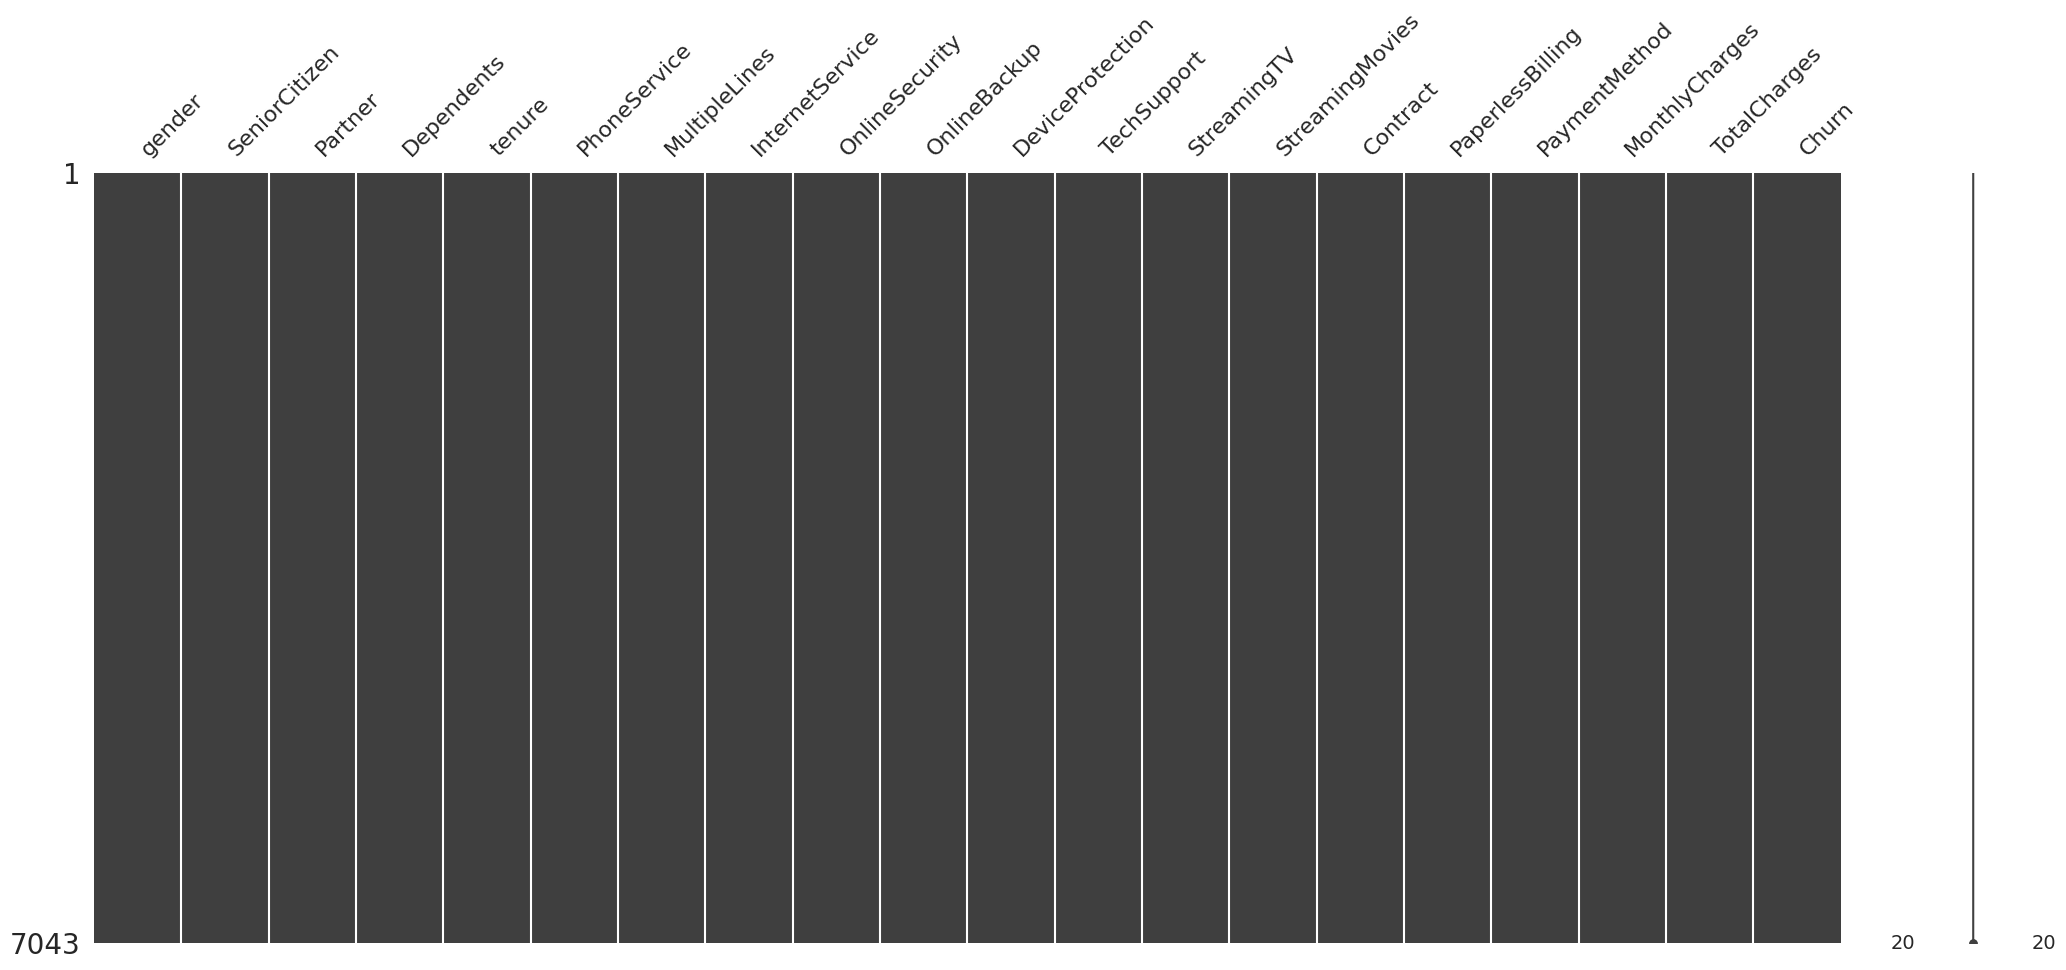

In [137]:
import missingno as msno
msno.matrix(df)

In [138]:
df.duplicated().sum()

np.int64(22)

In [139]:
df['Churn'].value_counts()

,count
Churn,
No,5174
Yes,1869


<Axes: xlabel='Churn', ylabel='count'>

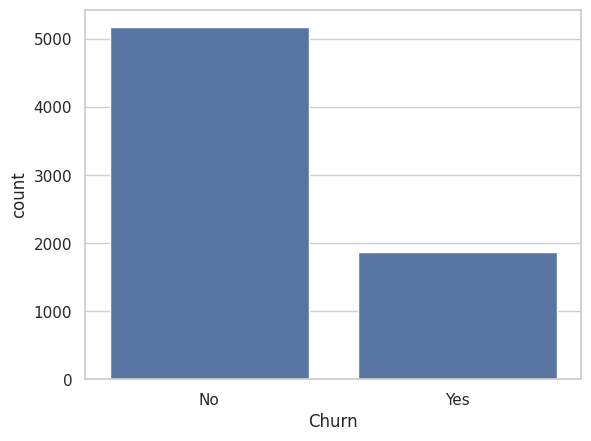

In [140]:
sns.countplot(x='Churn', data=df)

Univariate Analysis

In [141]:
categorical_cols = df.select_dtypes(include='object').columns.tolist()
numerical_cols = df.select_dtypes(include=['int64', 'float64']).columns.tolist()

In [142]:
# remove target from categorical
categorical_cols.remove('Churn')

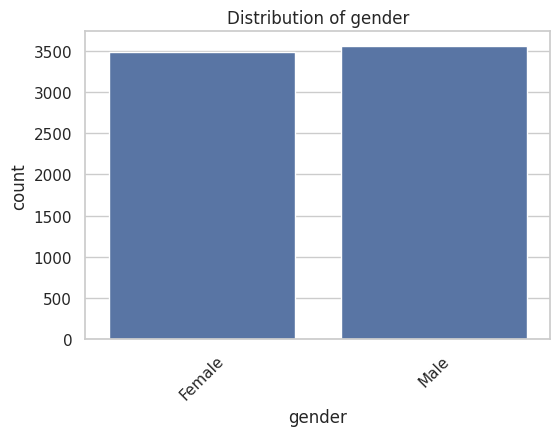

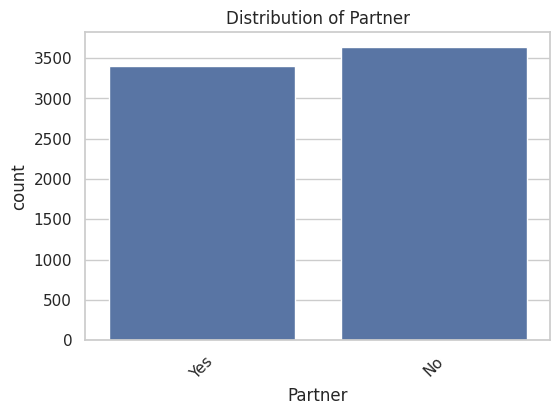

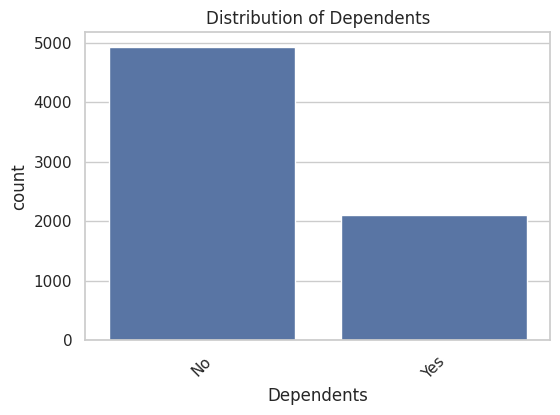

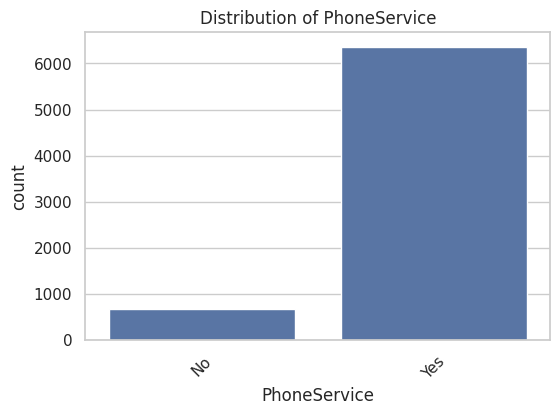

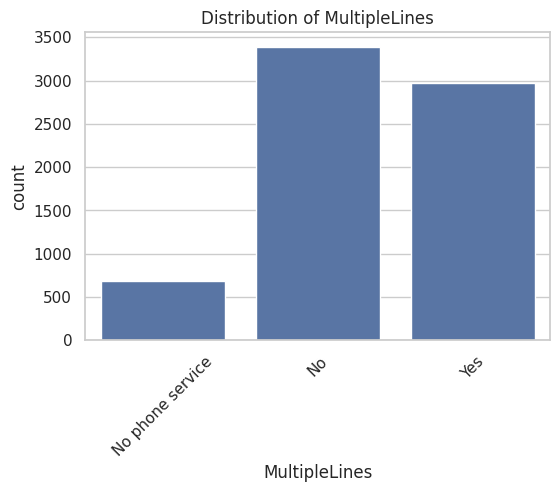

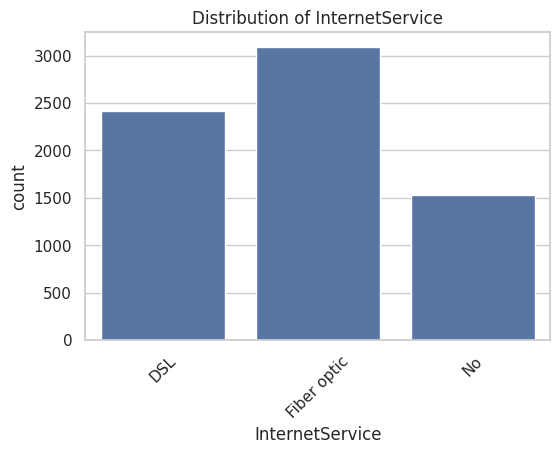

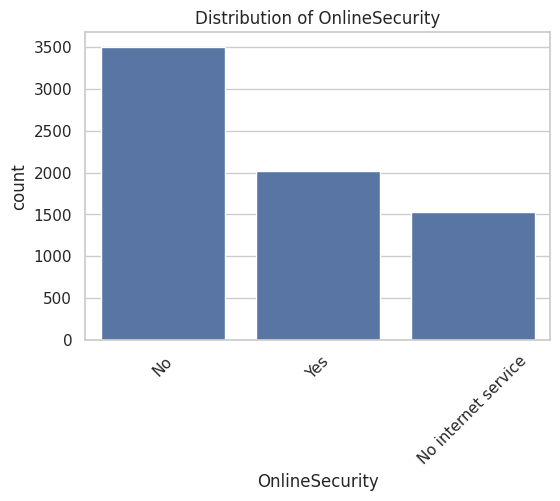

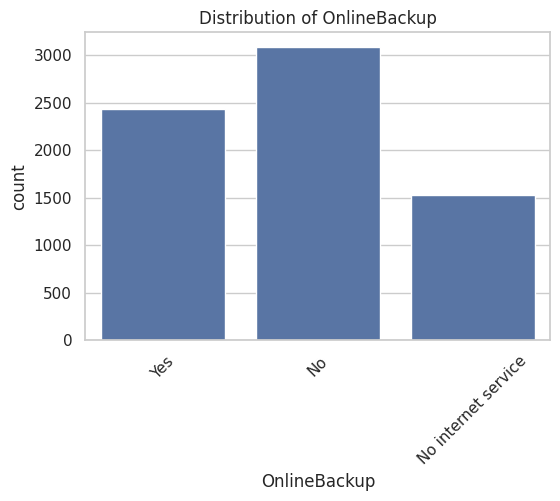

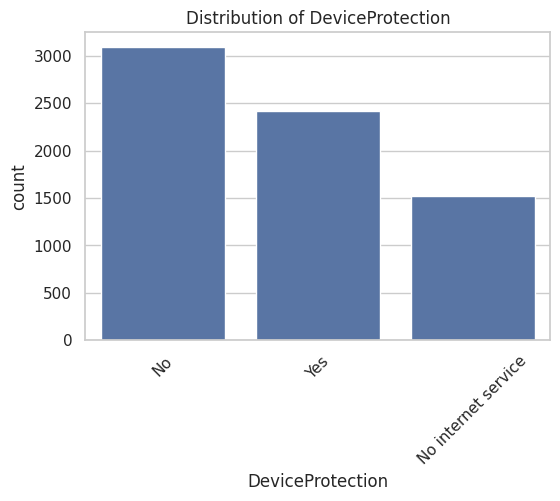

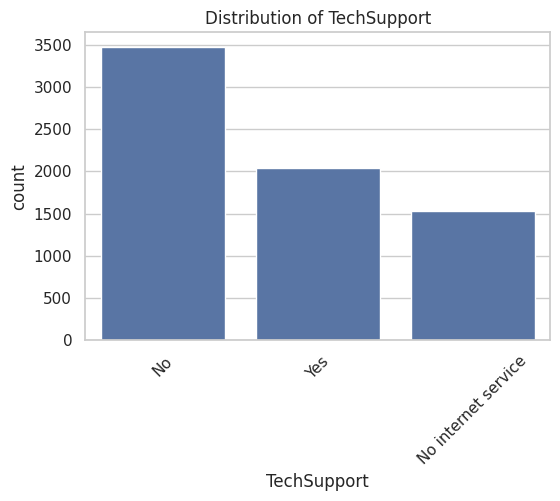

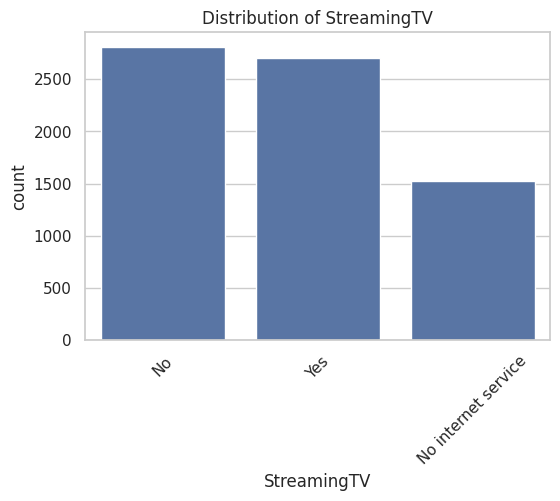

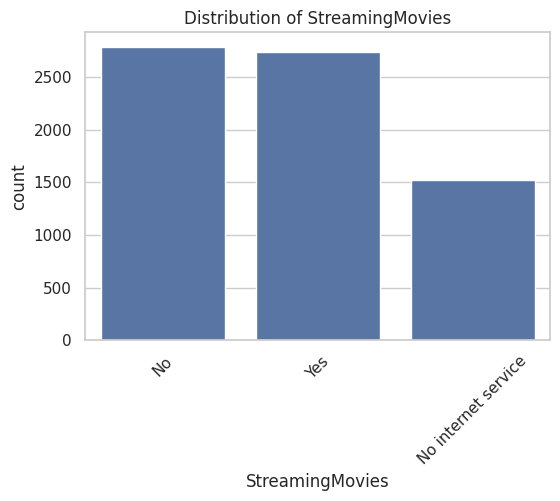

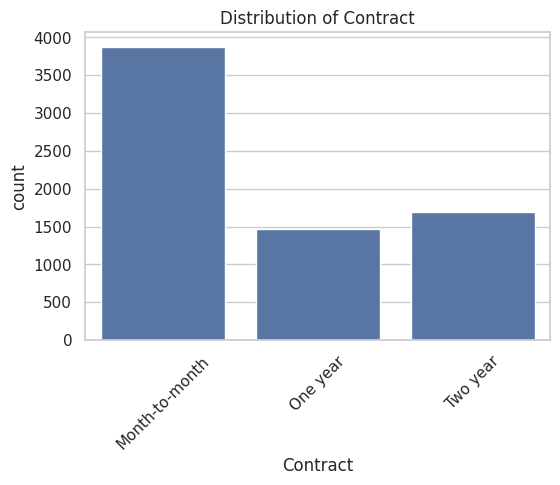

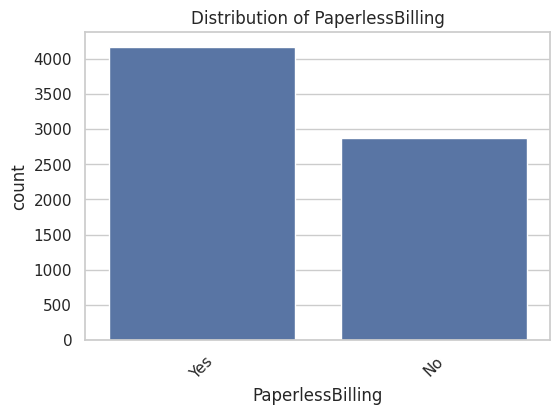

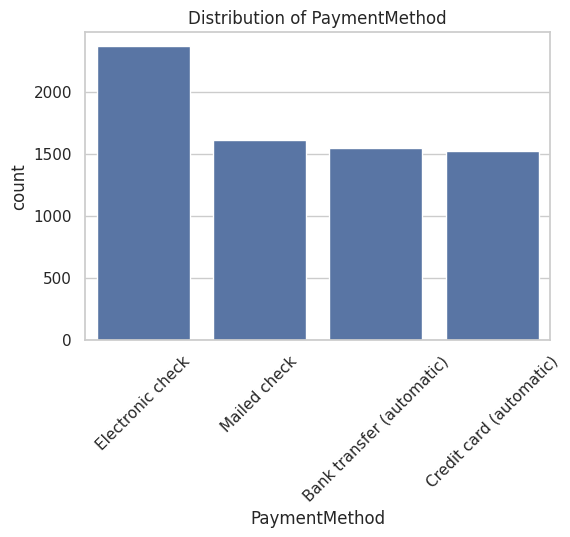

In [143]:
# Categorical features
for col in categorical_cols:
    plt.figure(figsize=(6,4))
    sns.countplot(x=col, data=df)
    plt.title(f"Distribution of {col}")
    plt.xticks(rotation=45)
    plt.show()

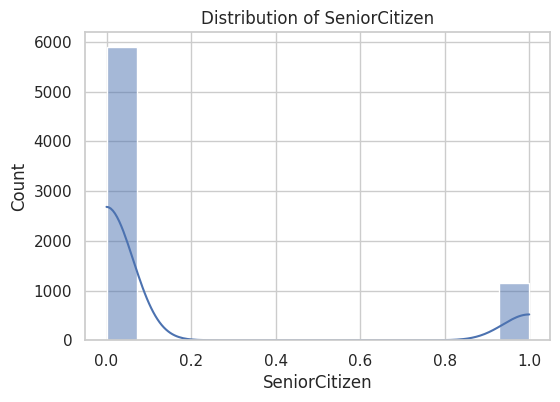

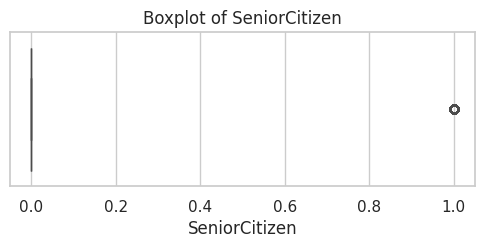

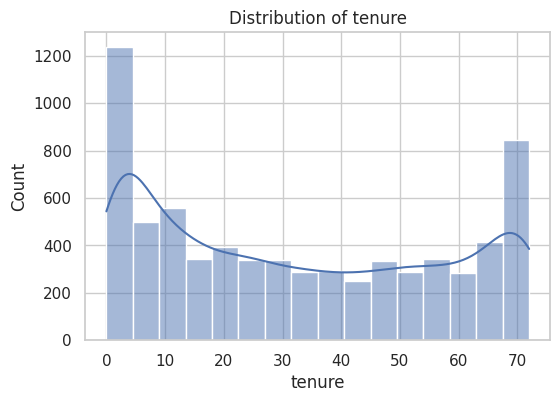

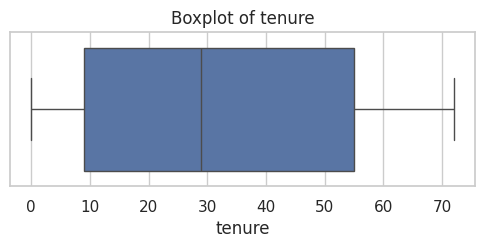

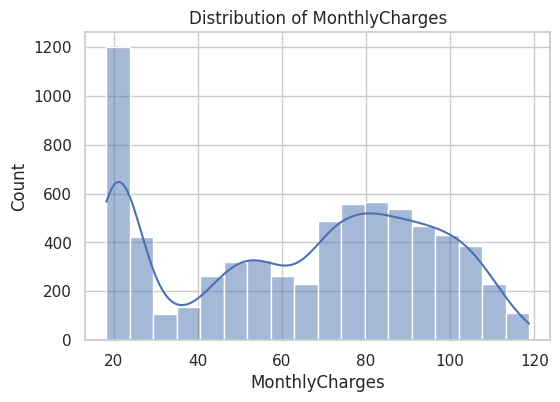

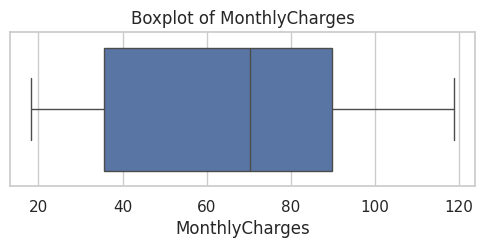

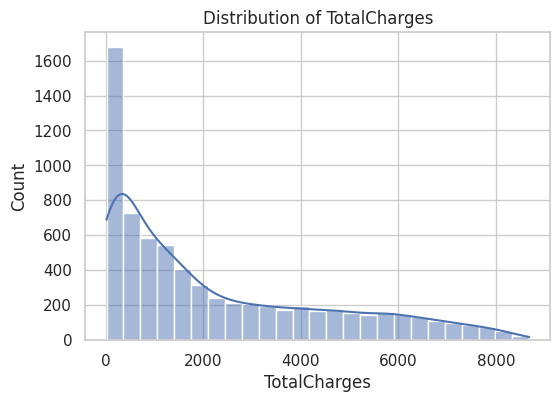

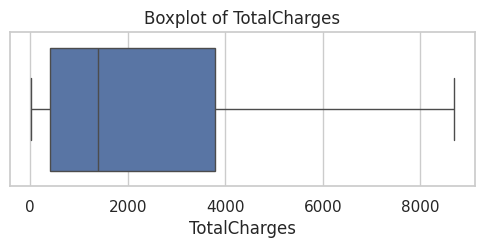

In [144]:
# Numerical features
for col in numerical_cols:
    plt.figure(figsize=(6,4))
    sns.histplot(df[col], kde=True)
    plt.title(f"Distribution of {col}")
    plt.show()

    plt.figure(figsize=(6,2))
    sns.boxplot(x=df[col])
    plt.title(f"Boxplot of {col}")
    plt.show()

Bivariate analysis

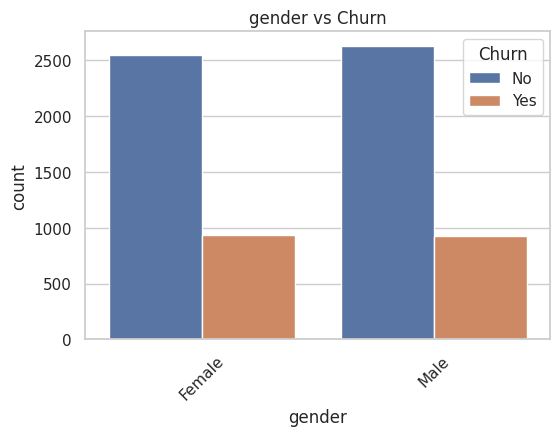

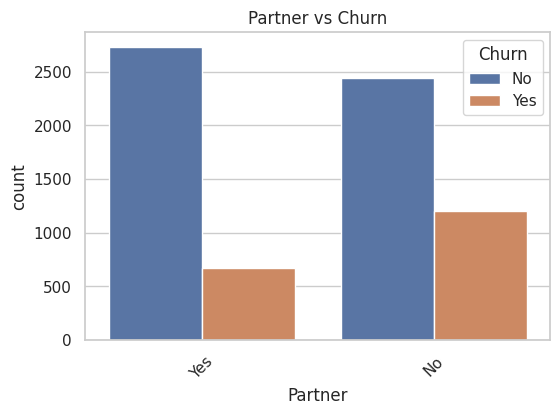

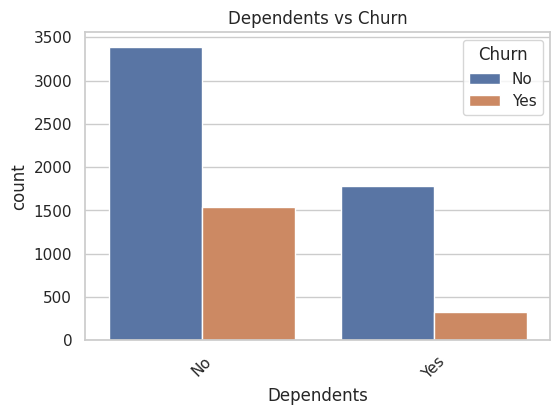

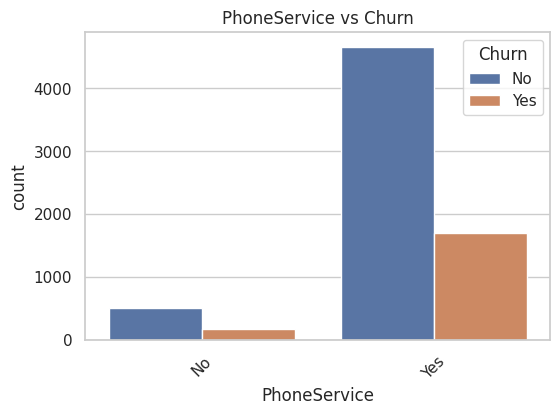

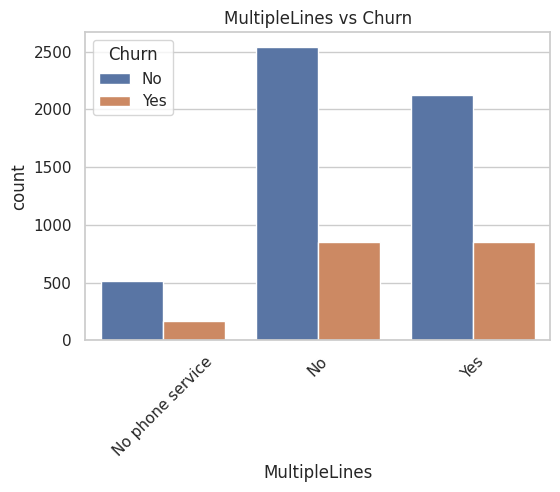

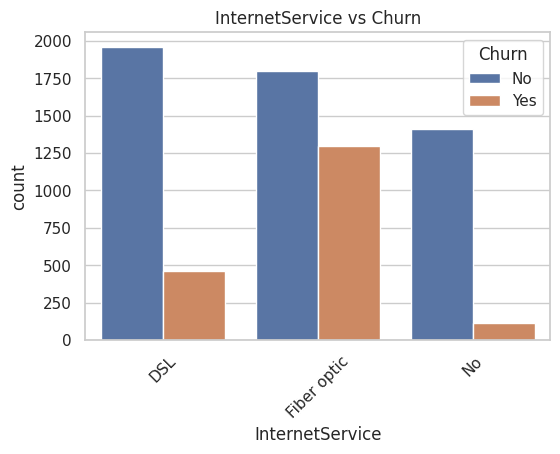

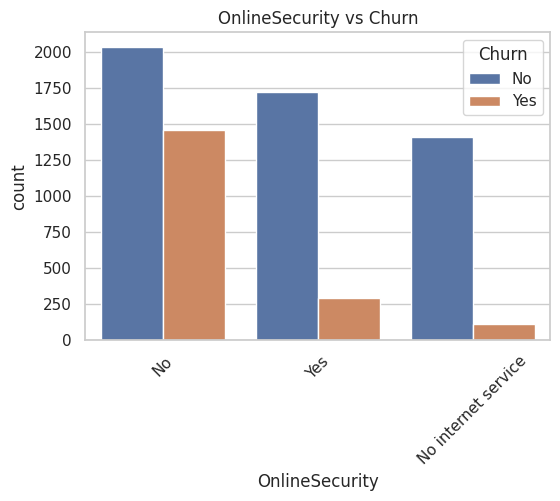

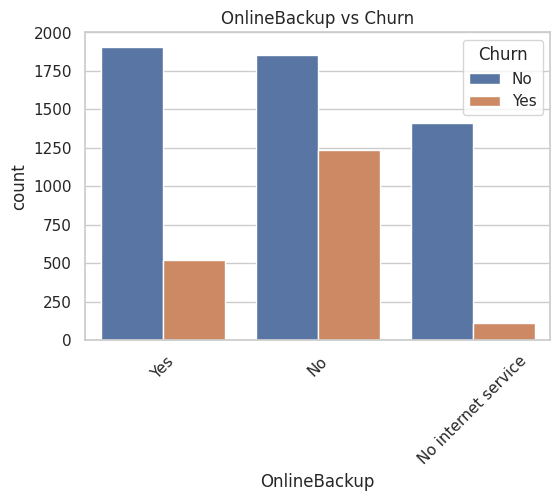

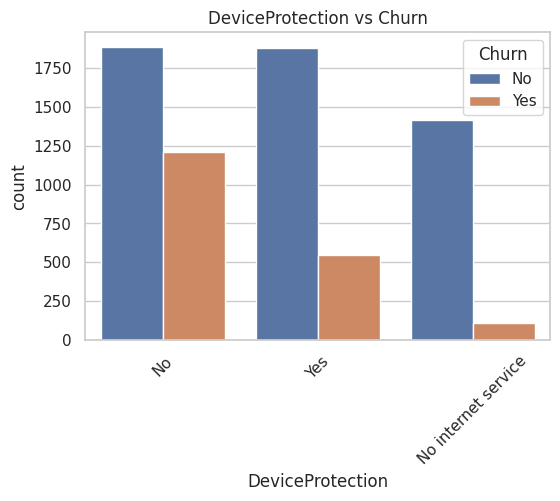

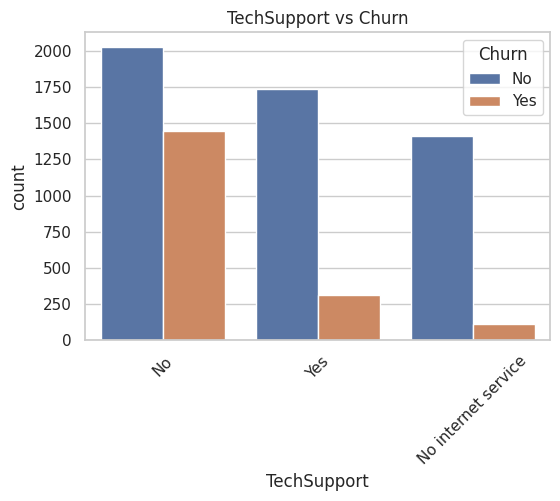

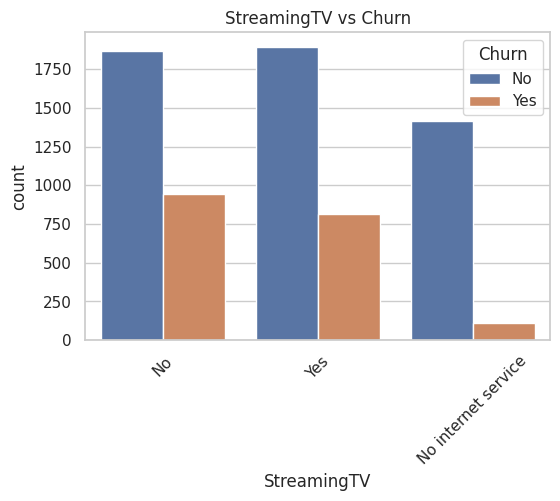

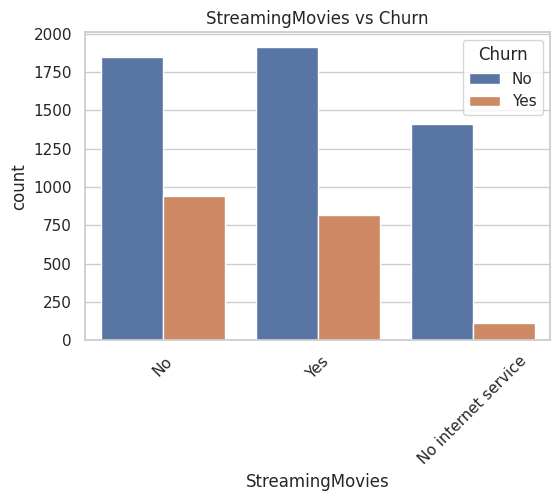

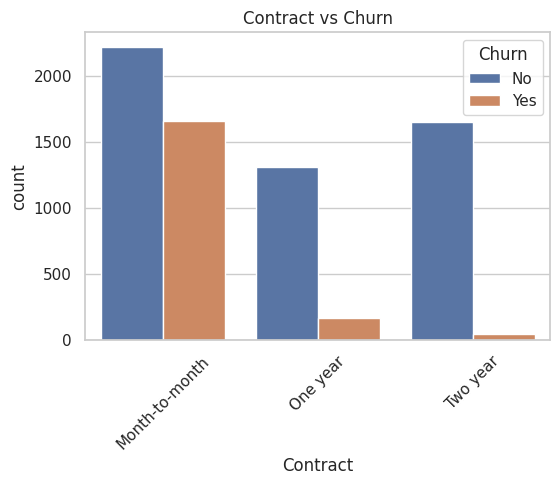

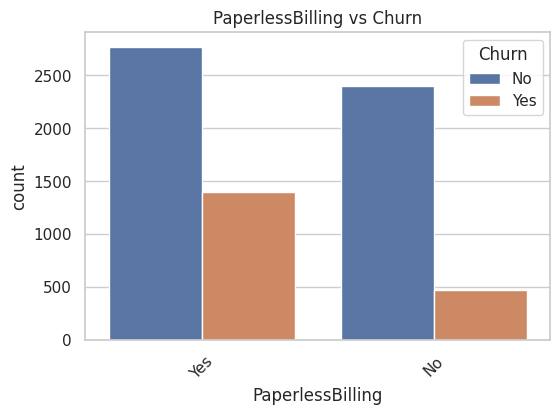

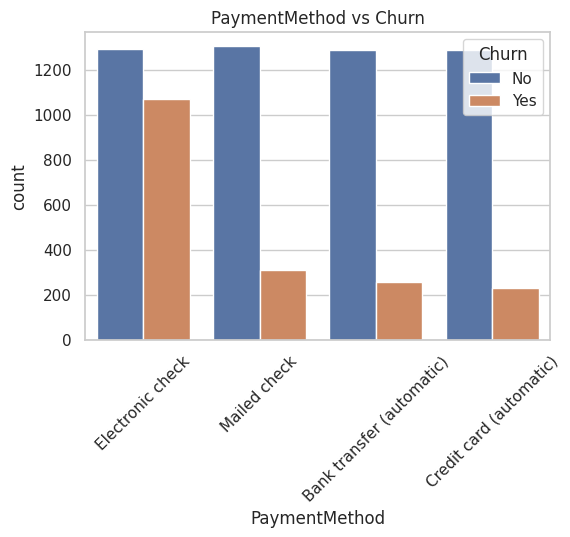

In [145]:
# Categorical vs Churn
for col in categorical_cols:
    plt.figure(figsize=(6,4))
    sns.countplot(x=col, hue='Churn', data=df)
    plt.title(f"{col} vs Churn")
    plt.xticks(rotation=45)
    plt.show()

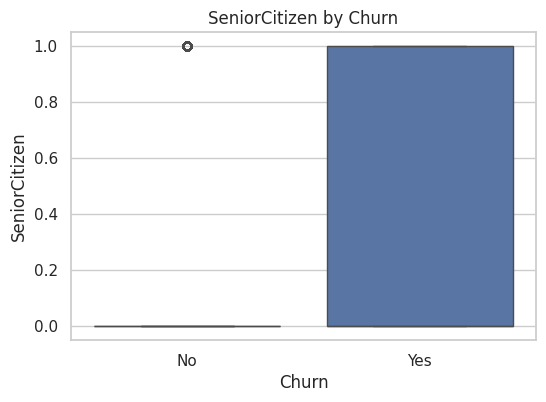

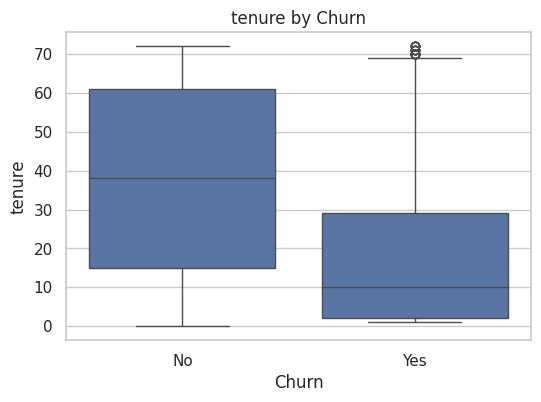

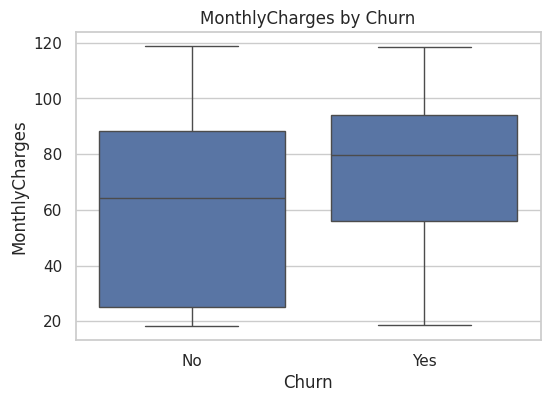

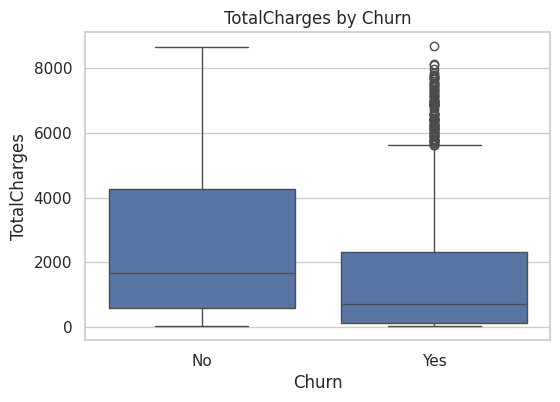

In [146]:
# Numerical vs Churn
for col in numerical_cols:
    plt.figure(figsize=(6,4))
    sns.boxplot(x='Churn', y=col, data=df)
    plt.title(f"{col} by Churn")
    plt.show()

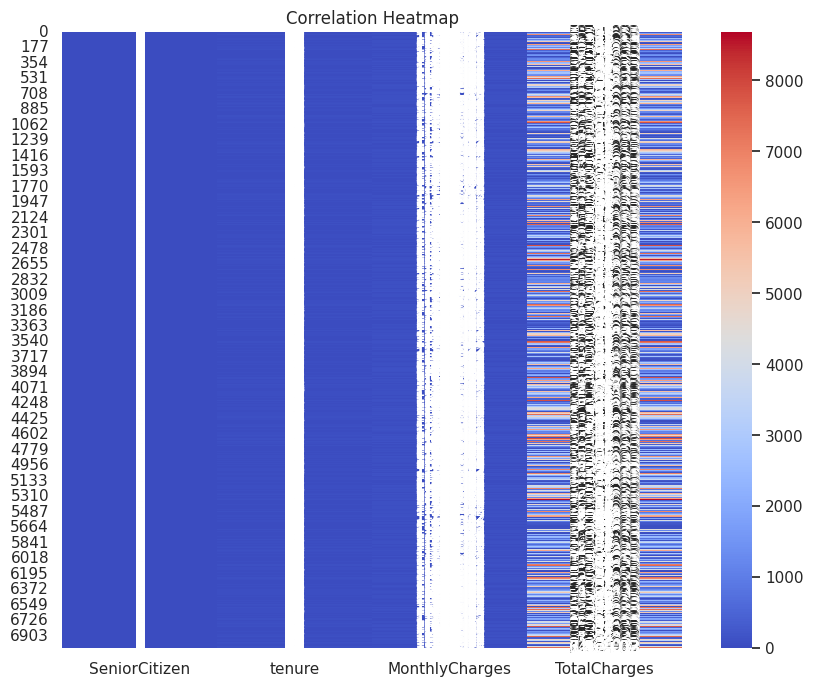

In [147]:
# corelation heatmap
plt.figure(figsize=(10,8))
sns.heatmap(df[numerical_cols], annot=True, cmap='coolwarm')
plt.title("Correlation Heatmap")
plt.show()

categorical features - analysis

In [148]:
df.columns

Index(['gender', 'SeniorCitizen', 'Partner', 'Dependents', 'tenure',
       'PhoneService', 'MultipleLines', 'InternetService', 'OnlineSecurity',
       'OnlineBackup', 'DeviceProtection', 'TechSupport', 'StreamingTV',
       'StreamingMovies', 'Contract', 'PaperlessBilling', 'PaymentMethod',
       'MonthlyCharges', 'TotalCharges', 'Churn'],
      dtype='object')

In [149]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 7043 entries, 0 to 7042
Data columns (total 20 columns):
 #   Column            Non-Null Count  Dtype  
---  ------            --------------  -----  
 0   gender            7043 non-null   object 
 1   SeniorCitizen     7043 non-null   int64  
 2   Partner           7043 non-null   object 
 3   Dependents        7043 non-null   object 
 4   tenure            7043 non-null   int64  
 5   PhoneService      7043 non-null   object 
 6   MultipleLines     7043 non-null   object 
 7   InternetService   7043 non-null   object 
 8   OnlineSecurity    7043 non-null   object 
 9   OnlineBackup      7043 non-null   object 
 10  DeviceProtection  7043 non-null   object 
 11  TechSupport       7043 non-null   object 
 12  StreamingTV       7043 non-null   object 
 13  StreamingMovies   7043 non-null   object 
 14  Contract          7043 non-null   object 
 15  PaperlessBilling  7043 non-null   object 
 16  PaymentMethod     7043 non-null   object 


countplot for categorical columns

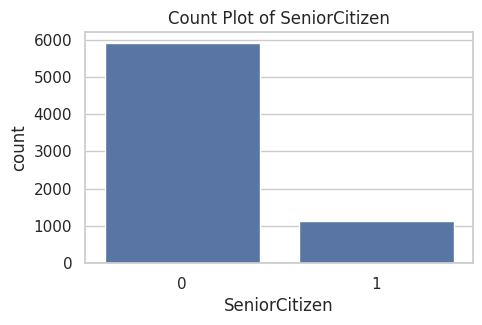

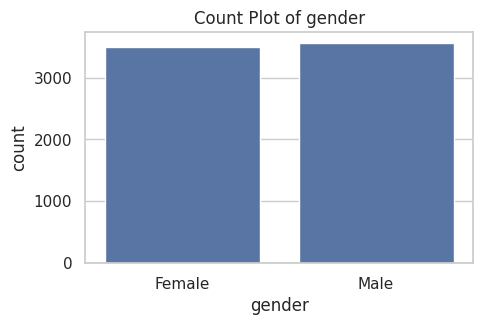

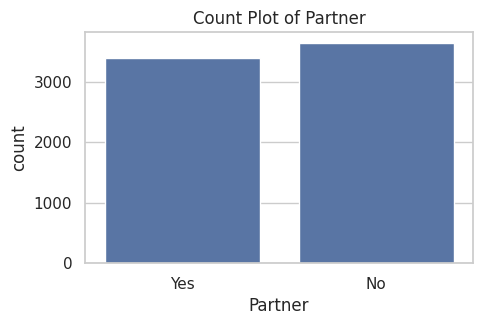

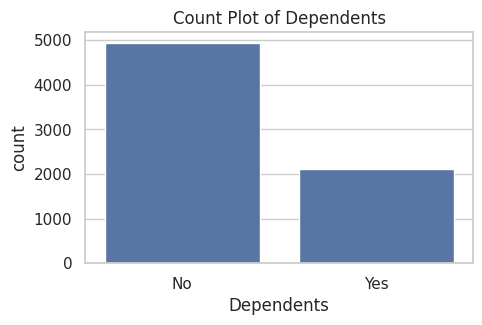

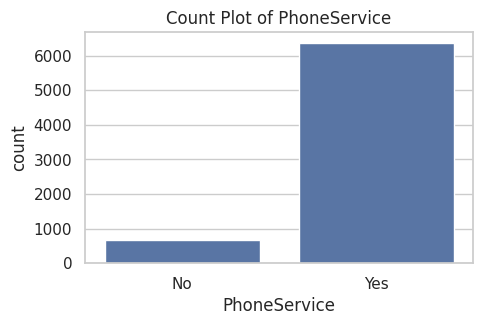

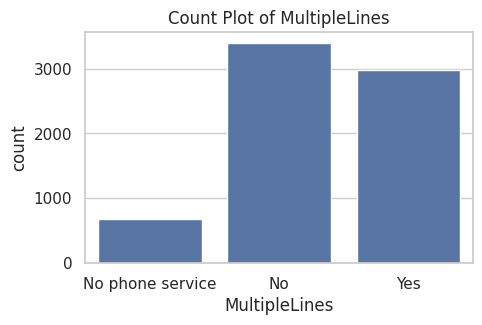

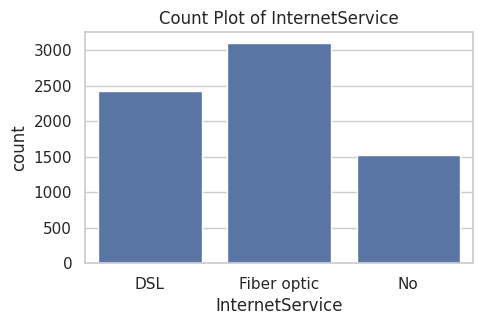

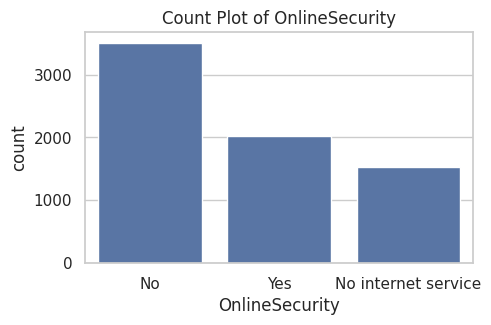

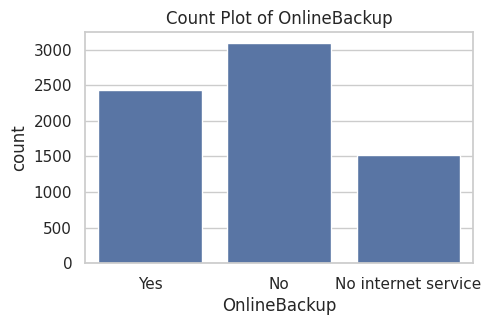

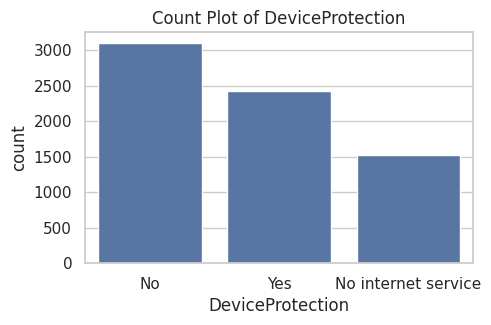

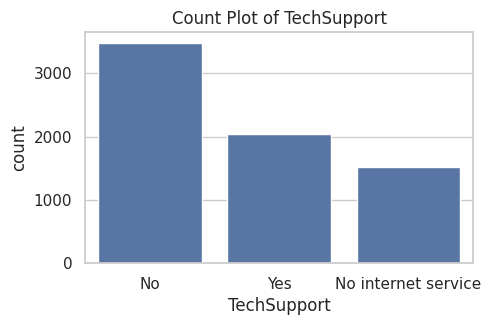

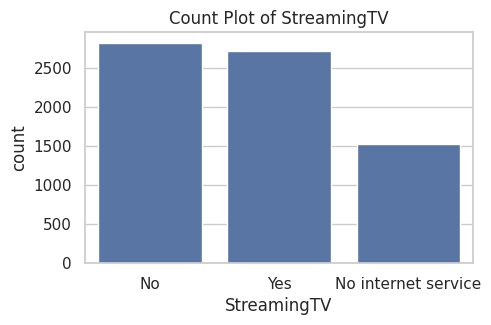

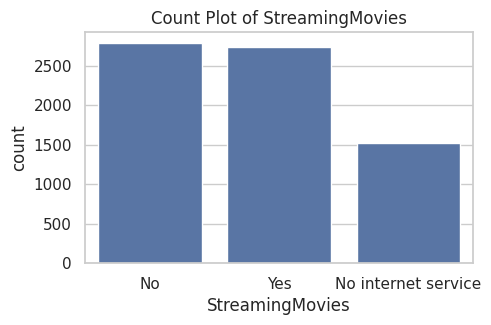

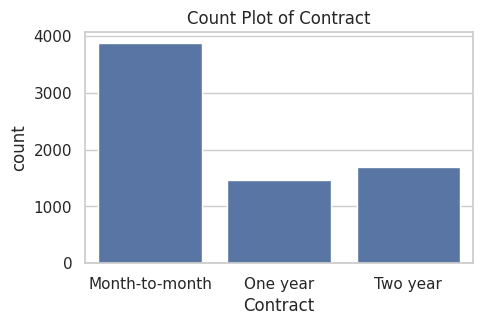

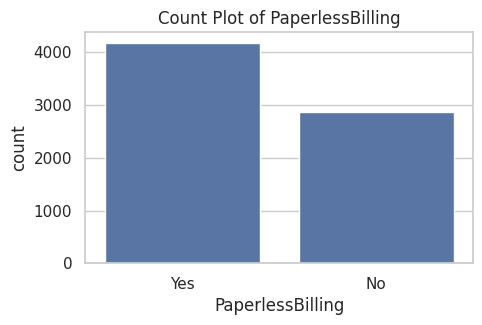

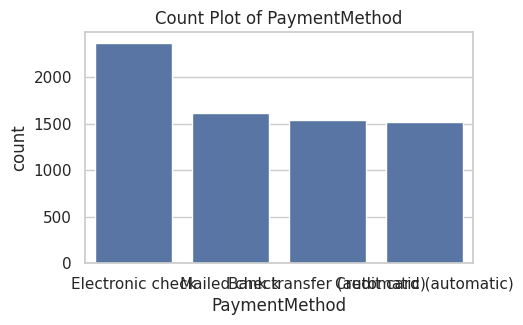

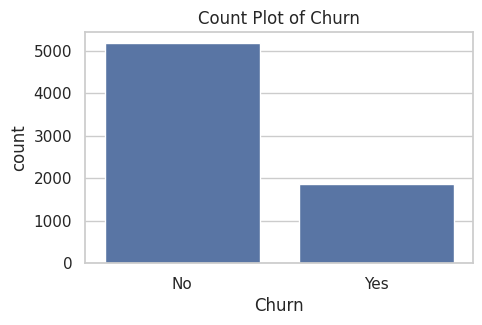

In [150]:
object_cols = df.select_dtypes(include="object").columns.to_list()

object_cols = ["SeniorCitizen"] + object_cols

for col in object_cols:
  plt.figure(figsize=(5, 3))
  sns.countplot(x=df[col])
  plt.title(f"Count Plot of {col}")
  plt.show()

# 4. Feature Engineering

In [151]:
# Feature Engineering: Create tenure bins
df['tenure_group'] = pd.cut(df['tenure'], bins=[0, 12, 24, 48, 60, 72],
                            labels=['0-12', '13-24', '25-48', '49-60', '61-72'])

In [152]:
# One-hot encode the new feature
df = pd.get_dummies(df, columns=['tenure_group'], drop_first=True)

Encoding for categorical columns

In [153]:
# label encoding for target column
df["Churn"] = df["Churn"].replace({"Yes": 1, "No": 0})

In [154]:
# Encode binary columns with LabelEncoder
binary_cols = ["gender", "Partner", "Dependents", "PhoneService", "PaperlessBilling"]
le = LabelEncoder()
for col in binary_cols:
  df[col] = le.fit_transform(df[col])

In [155]:
# ordinal encodeing for 'contract'
contract_mapping = {'Month-to-month': 0, 'One year': 1, 'Two year': 2}
df['Contract'] = df['Contract'].map(contract_mapping)

In [156]:
# one hot encode for all others
one_hot_cols = ['MultipleLines', 'InternetService', 'OnlineSecurity', 'OnlineBackup',
                'DeviceProtection', 'TechSupport', 'StreamingTV', 'StreamingMovies', 'PaymentMethod']

df = pd.get_dummies(df, columns=one_hot_cols, drop_first=True)

# 5. Train-Test Split and SMOTE

In [157]:
# splitting the features and target
X = df.drop(columns=["Churn"])
y = df["Churn"]

In [158]:
# split training and test data
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

In [159]:
print(y_train.shape)

(5634,)


In [160]:
# Apply Synthetic Minority Oversampling Technique (SMOTE) to handle class imbalance

smote = SMOTE(random_state=42)
X_train_smote, y_train_smote = smote.fit_resample(X_train, y_train)

In [162]:
print(y_train_smote.shape)

(8276,)


# 6. Model Training and Evaluation

Training with default hyperparameters

In [163]:
#Define the  models
models = {
    "Decision Tree": DecisionTreeClassifier(random_state=42),
    "Random Forest": RandomForestClassifier(random_state=42),
    "XGBoost": XGBClassifier(random_state=42)
}

In [164]:
def evaluate_model(name, y_true, y_pred, y_proba):
    print(f"\n{name} Evaluation Metrics:")
    print("Accuracy:", accuracy_score(y_true, y_pred))
    print("F1 Score:", f1_score(y_true, y_pred))
    print("Recall:", recall_score(y_true, y_pred))
    print("ROC AUC Score:", roc_auc_score(y_true, y_proba))

In [165]:
# Train and evaluate each models
for name, model in models.items():
    model.fit(X_train_smote, y_train_smote)
    y_pred = model.predict(X_test)
    y_proba = model.predict_proba(X_test)[:, 1]
    evaluate_model(name, y_test, y_pred, y_proba)


Decision Tree Evaluation Metrics:
Accuracy: 0.7267565649396736
F1 Score: 0.508301404853129
Recall: 0.5335120643431636
ROC AUC Score: 0.6655405405405406

Random Forest Evaluation Metrics:
Accuracy: 0.7785663591199432
F1 Score: 0.5783783783783784
Recall: 0.5737265415549598
ROC AUC Score: 0.8289254401854937

XGBoost Evaluation Metrics:
Accuracy: 0.7735982966643009
F1 Score: 0.581913499344692
Recall: 0.5951742627345844
ROC AUC Score: 0.8249764509818128


# 7. Hyperparameter Tuning

In [166]:
# GridSearch for Random Forest
param_grid = {
    'n_estimators': [100, 200],
    'max_depth': [None, 10],
    'min_samples_split': [2, 5],
    'min_samples_leaf': [1, 2]
}

grid_search = GridSearchCV(estimator=RandomForestClassifier(random_state=42),
                           param_grid=param_grid, cv=5,
                           scoring='accuracy', n_jobs=-1)
grid_search.fit(X_train_smote, y_train_smote)
best_params = grid_search.best_params_

In [167]:
# Train best Random Forest
best_rfc = RandomForestClassifier(**best_params, random_state=42)
best_rfc.fit(X_train_smote, y_train_smote)
y_test_pred = best_rfc.predict(X_test)
y_test_proba = best_rfc.predict_proba(X_test)[:, 1]

evaluate_model("Tuned Random Forest", y_test, y_test_pred, y_test_proba)


Tuned Random Forest Evaluation Metrics:
Accuracy: 0.7806955287437899
F1 Score: 0.582995951417004
Recall: 0.579088471849866
ROC AUC Score: 0.8331966110116245


# 8. ROC Curve

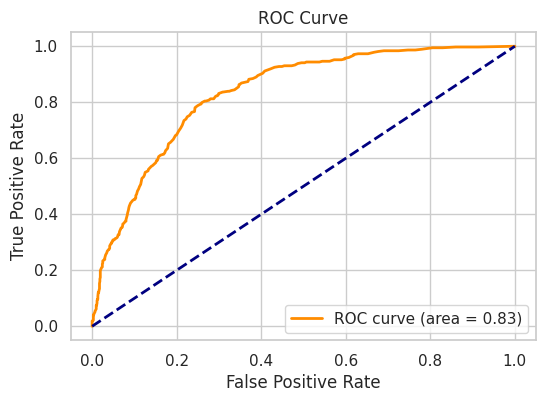

In [168]:
# ROC Curve
fpr, tpr, _ = roc_curve(y_test, y_test_proba)
roc_auc = roc_auc_score(y_test, y_test_proba)
plt.figure(figsize=(6, 4))
plt.plot(fpr, tpr, color='darkorange', lw=2, label=f'ROC curve (area = {roc_auc:.2f})')
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curve')
plt.legend(loc='lower right')
plt.show()

# 9. Ensemble model

In [169]:
# Voting Classifier
voting_clf = VotingClassifier(
    estimators=[
        ('dt', DecisionTreeClassifier(random_state=42)),
        ('rf', RandomForestClassifier(**best_params, random_state=42)),
        ('xgb', XGBClassifier(random_state=42))
    ],
    voting='soft')

voting_clf.fit(X_train_smote, y_train_smote)
y_pred_vote = voting_clf.predict(X_test)
y_proba_vote = voting_clf.predict_proba(X_test)[:, 1]
evaluate_model("Voting Classifier", y_test, y_pred_vote, y_proba_vote)


Voting Classifier Evaluation Metrics:
Accuracy: 0.7565649396735273
F1 Score: 0.5444887118193891
Recall: 0.5495978552278821
ROC AUC Score: 0.8181769954558158
